In [1]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=77739cdba11ebe984dffa09eec4f56729b72e214e145bd92fdf12b311c25a566
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=41248824eaa2f2a322c4a5b2f700ef714374664f0af8eea0d583f49708ee5d90
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [2]:
import os
import numpy as np
import time 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches  # Import mpatches here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix



In [3]:
data_path = '/kaggle/input/cs604-project/'

# List the contents of the data directory
print(os.listdir(data_path))

['train_images', 'train_masks']


In [4]:
import math

total_images = 1631

# Calculate the number of images for each set
train_size = int(0.90 * total_images)
val_size = int(0.10 * total_images)
# test_size = total_images - train_size - val_size  # Adjust for any rounding errors

print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")
# print(f"Test images: {test_size}")

Training images: 1467
Validation images: 163


In [5]:
image_dir = '/kaggle/input/cs604-project/train_images/'
mask_dir = '/kaggle/input/cs604-project/train_masks/'

# image_dir = f'{data_path}/train_images/'
# mask_dir = f'{data_path}/train_masks/'

all_filenames = sorted(os.listdir(image_dir))

In [6]:
from sklearn.model_selection import train_test_split

# First split into training and temp (validation)
train_filenames, val_filenames = train_test_split(all_filenames,test_size=(val_size),random_state=42)

# Now split temp into validation and test
# val_filenames, test_filenames = train_test_split(temp_filenames,test_size=test_size,random_state=42)

print(f"Total images: {len(all_filenames)}")
print(f"Training images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
# print(f"Test images: {len(test_filenames)}")


Total images: 1631
Training images: 1468
Validation images: 163


In [7]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name  # Since filenames match
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' mode for grayscale

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [8]:
from torchvision import transforms

transform_image = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
   # Normalize using ImageNet mean and std if desired
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),  # Converts to tensor without normalization
    transforms.Lambda(lambda x: x.squeeze().long())  # Remove channel dimension and convert to long
])


In [9]:
# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

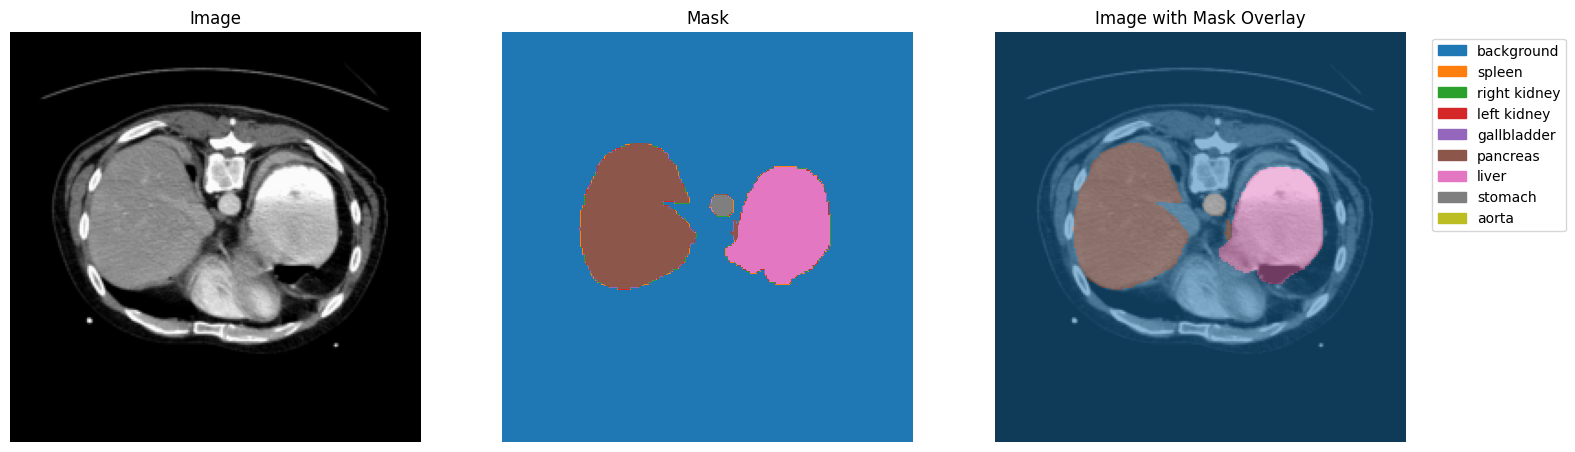

In [10]:
def visualize_sample(dataset, idx=None, filename=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors as mcolors
    from PIL import Image

    # Load image and mask
    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")

    # Prepare image for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.numpy()

    # Define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors
    colormap = mcolors.ListedColormap(colors[:9])

    # Create color mask
    mask_rgba = colormap(mask_np / 8.0)
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # Plot image and mask
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask_np, cmap=colormap, vmin=0, vmax=8)
    ax2.set_title('Mask')
    ax2.axis('off')

    ax3.imshow(image_np)
    ax3.imshow(mask_rgba, interpolation='none')
    ax3.set_title('Image with Mask Overlay')
    ax3.axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

visualize_sample(train_dataset, idx=1)


In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode='transpose'):
        super(UpBlock, self).__init__()
        if mode == 'transpose':
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        elif mode == 'bilinear':
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
        else:
            raise ValueError("Invalid mode for upsampling. Choose 'transpose' or 'bilinear'.")

    def forward(self, x):
        return self.up(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Initializes the Attention Gate.

        Args:
            F_g (int): Number of channels in the gating signal (decoder feature map).
            F_l (int): Number of channels in the skip connection (encoder feature map).
            F_int (int): Number of intermediate channels.
        """
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        Forward pass of the Attention Gate.

        Args:
            g (torch.Tensor): Gating signal from the decoder.
            x (torch.Tensor): Skip connection from the encoder.

        Returns:
            torch.Tensor: Refined encoder features.
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi
    
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, dropout=0.5):
        super(UNetPlusPlus, self).__init__()
        
        # Load the pretrained ResNet34 model
        resnet = models.resnet34(pretrained=True)
        
        # Extract layers from ResNet34 to build the encoder
        self.encoder = nn.ModuleList([
            resnet.conv1,   # [64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # [64, H/4, W/4]
            resnet.layer1,  # [64, H/4, W/4]
            resnet.layer2,  # [128, H/8, W/8]
            resnet.layer3,  # [256, H/16, W/16]
            resnet.layer4   # [512, H/32, W/32]
        ])
        
        nb_filter = [64, 64, 128, 256, 512]
        
        # Decoder
        self.up3_1 = UpBlock(nb_filter[4], nb_filter[3])
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3], dropout=dropout)
        
        self.up2_2 = UpBlock(nb_filter[3], nb_filter[2])
        self.conv2_2 = ConvBlock(nb_filter[3], nb_filter[2], dropout=dropout)
        
        self.up1_3 = UpBlock(nb_filter[2], nb_filter[1])
        self.conv1_3 = ConvBlock(nb_filter[2], nb_filter[1], dropout=dropout)
        
        self.up0_4 = UpBlock(nb_filter[1], nb_filter[0])
        self.conv0_4 = ConvBlock(nb_filter[1] + nb_filter[0], nb_filter[0], dropout=dropout)
        
        # **Extra Upsampling Layer to Restore Original Spatial Dimensions**
        self.up_extra = UpBlock(nb_filter[0], nb_filter[0])
        self.conv_extra = ConvBlock(nb_filter[0] + in_channels, nb_filter[0], dropout=dropout)
        
        # Final Output Layer
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x0 = self.encoder[0](x)    # conv1
        x0 = self.encoder[1](x0)   # bn1
        x0 = self.encoder[2](x0)   # relu

        x0p = self.encoder[3](x0)  # maxpool

        x1 = self.encoder[4](x0p)  # layer1
        x2 = self.encoder[5](x1)   # layer2
        x3 = self.encoder[6](x2)   # layer3
        x4 = self.encoder[7](x3)   # layer4

        # Decoder
        x3_1 = self.up3_1(x4)
        x3_1 = torch.cat([x3_1, x3], dim=1)
        x3_1 = self.conv3_1(x3_1)

        x2_2 = self.up2_2(x3_1)
        x2_2 = torch.cat([x2_2, x2], dim=1)
        x2_2 = self.conv2_2(x2_2)

        x1_3 = self.up1_3(x2_2)
        x1_3 = torch.cat([x1_3, x1], dim=1)
        x1_3 = self.conv1_3(x1_3)

        x0_4 = self.up0_4(x1_3)
        x0_4 = torch.cat([x0_4, x0], dim=1)
        x0_4 = self.conv0_4(x0_4)

        # **Extra upsampling to match input size**
        x_extra = self.up_extra(x0_4)
        x_extra = torch.cat([x_extra, x], dim=1)  # Concatenate with original input
        x_extra = self.conv_extra(x_extra)

        output = self.final(x_extra)
        return output



In [12]:
class UNetPlusPlus_Attention(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, dropout=0.5, attention_mode='concatenate'):
        """
        Initializes the Attention U-Net++ model with a ResNet34 encoder.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output classes.
            dropout (float): Dropout rate.
            attention_mode (str): Mode of attention ('concatenate' or 'add').
        """
        super(UNetPlusPlus_Attention, self).__init__()

        # Load the pretrained ResNet34 model
        resnet = models.resnet34(pretrained=True)

        # Extract layers from ResNet34 to build the encoder
        self.encoder = nn.ModuleList([
            resnet.conv1,   # [64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # [64, H/4, W/4]
            resnet.layer1,  # [64, H/4, W/4]
            resnet.layer2,  # [128, H/8, W/8]
            resnet.layer3,  # [256, H/16, W/16]
            resnet.layer4   # [512, H/32, W/32]
        ])

        # Number of filters at each encoder stage
        nb_filter = [64, 64, 128, 256, 512]

        # Attention Gates
        self.att3_1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.att2_2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.att1_3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.att0_4 = AttentionGate(F_g=64, F_l=64, F_int=32)

        # Decoder Blocks with Attention
        self.up3_1 = UpBlock(nb_filter[4], nb_filter[3])
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3], dropout=dropout)

        self.up2_2 = UpBlock(nb_filter[3], nb_filter[2])
        self.conv2_2 = ConvBlock(nb_filter[3], nb_filter[2], dropout=dropout)

        self.up1_3 = UpBlock(nb_filter[2], nb_filter[1])
        self.conv1_3 = ConvBlock(nb_filter[2], nb_filter[1], dropout=dropout)

        self.up0_4 = UpBlock(nb_filter[1], nb_filter[0])
        self.conv0_4 = ConvBlock(nb_filter[1] + nb_filter[0], nb_filter[0], dropout=dropout)

        # Extra Upsampling Layer to Restore Original Spatial Dimensions
        self.up_extra = UpBlock(nb_filter[0], nb_filter[0])
        self.conv_extra = ConvBlock(nb_filter[0] + in_channels, nb_filter[0], dropout=dropout)

        # Final Output Layer
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.encoder[0](x)    # conv1
        x0 = self.encoder[1](x0)   # bn1
        x0 = self.encoder[2](x0)   # relu

        x0p = self.encoder[3](x0)  # maxpool

        x1 = self.encoder[4](x0p)  # layer1
        x2 = self.encoder[5](x1)   # layer2
        x3 = self.encoder[6](x2)   # layer3
        x4 = self.encoder[7](x3)   # layer4

        # Decoder with Attention Gates
        x3_1 = self.up3_1(x4)
        x3_att = self.att3_1(g=x3_1, x=x3)
        x3_1 = torch.cat([x3_1, x3_att], dim=1)
        x3_1 = self.conv3_1(x3_1)

        x2_2 = self.up2_2(x3_1)
        x2_att = self.att2_2(g=x2_2, x=x2)
        x2_2 = torch.cat([x2_2, x2_att], dim=1)
        x2_2 = self.conv2_2(x2_2)

        x1_3 = self.up1_3(x2_2)
        x1_att = self.att1_3(g=x1_3, x=x1)
        x1_3 = torch.cat([x1_3, x1_att], dim=1)
        x1_3 = self.conv1_3(x1_3)

        x0_4 = self.up0_4(x1_3)
        x0_att = self.att0_4(g=x0_4, x=x0)
        x0_4 = torch.cat([x0_4, x0_att], dim=1)
        x0_4 = self.conv0_4(x0_4)

        # Extra upsampling to match input size
        x_extra = self.up_extra(x0_4)
        x_extra = torch.cat([x_extra, x], dim=1)  # Concatenate with original input
        x_extra = self.conv_extra(x_extra)

        output = self.final(x_extra)
        return output

In [13]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [14]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [15]:
def compute_iou(preds, labels, num_classes):
    preds = preds.view(-1)
    labels = labels.view(-1)
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection[cls] = (pred_inds & label_inds).sum().item()
        union[cls] = (pred_inds | label_inds).sum().item()

    return intersection, union

def compute_miou(intersection, union):
    iou_per_class = intersection / (union + 1e-6)  # Avoid division by zero
    miou = np.nanmean(iou_per_class)
    return miou, iou_per_class

In [16]:
def train_model(model, criterion, optimizer, num_epochs=10, patience=5):
    import numpy as np

    # Access the first convolutional layer of the encoder
    conv_layer = model.encoder[0]  # This is resnet.conv1
    before_mean = conv_layer.weight.data.mean().item()
    print(f"Before Training Mean: {before_mean:.6f}")
    
    best_miou = 0.0
    patience_counter = 0
    num_classes = 9  # Number of classes
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        intersection = np.zeros(num_classes)
        union = np.zeros(num_classes)
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Compute predictions
            _, preds = torch.max(outputs, 1)
            
            # Compute intersection and union for each class
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                label_inds = (labels == cls)
                intersection[cls] += torch.sum(pred_inds & label_inds).item()
                union[cls] += torch.sum(pred_inds | label_inds).item()
        
        epoch_loss = running_loss / len(train_dataset)
        train_miou, train_iou_per_class = compute_miou(intersection, union)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = np.zeros(num_classes)
        val_union = np.zeros(num_classes)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                
                # Compute predictions
                _, val_preds = torch.max(val_outputs, 1)
                
                # Compute intersection and union for each class
                for cls in range(num_classes):
                    pred_inds = (val_preds == cls)
                    label_inds = (val_labels == cls)
                    val_intersection[cls] += torch.sum(pred_inds & label_inds).item()
                    val_union[cls] += torch.sum(pred_inds | label_inds).item()
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_miou, val_iou_per_class = compute_miou(val_intersection, val_union)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}")
        for idx, iou in enumerate(train_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val mIoU: {val_miou:.4f}")
        for idx, iou in enumerate(val_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        
        # Check for improvement
        if val_miou > best_miou:
            best_miou = val_miou
            patience_counter = 0
            torch.save(model.state_dict(), 'UNetPlusPlusAttention.pth')
            print("Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
        model.train()
    
    # Get the weights of the same convolutional layer after training
    after_mean = conv_layer.weight.data.mean().item()
    print(f"After Training Mean: {after_mean:.6f}")
    
    # Save the final model
    torch.save(model.state_dict(), 'UNetPlusPlusAttention.pth')

In [17]:
# Define the init_weights function
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For Conv2d layers
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ConvTranspose2d layers
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)  # For BatchNorm2d layers
        nn.init.constant_(m.bias, 0)

# Initialize the model
model = UNetPlusPlus_Attention(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Initialize decoder weights
for name, module in model.named_modules():
    if 'encoder' not in name:
        module.apply(init_weights)

# Alternatively, you can specify the layers more precisely
# Initialize weights of ConvBlock and UpBlock layers
# for m in model.modules():
#     if isinstance(m, (ConvBlock, UpBlock)):
#         m.apply(init_weights)

# Define the loss function and  
criterion = weighted_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_model(model, criterion, optimizer, num_epochs=300, patience=10)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s]


Before Training Mean: 0.000108
Epoch 1/300
Train Loss: 2.6254, Train mIoU: 0.0812
 - Class 0 (background): IoU = 0.4899
 - Class 1 (spleen): IoU = 0.0084
 - Class 2 (right kidney): IoU = 0.0041
 - Class 3 (left kidney): IoU = 0.0070
 - Class 4 (gallbladder): IoU = 0.0009
 - Class 5 (pancreas): IoU = 0.2082
 - Class 6 (liver): IoU = 0.0086
 - Class 7 (stomach): IoU = 0.0025
 - Class 8 (aorta): IoU = 0.0015
Val Loss: 2.5651, Val mIoU: 0.1186
 - Class 0 (background): IoU = 0.7642
 - Class 1 (spleen): IoU = 0.0002
 - Class 2 (right kidney): IoU = 0.0060
 - Class 3 (left kidney): IoU = 0.0090
 - Class 4 (gallbladder): IoU = 0.0000
 - Class 5 (pancreas): IoU = 0.2812
 - Class 6 (liver): IoU = 0.0019
 - Class 7 (stomach): IoU = 0.0049
 - Class 8 (aorta): IoU = 0.0000
Model saved.
Epoch 2/300
Train Loss: 2.0657, Train mIoU: 0.1447
 - Class 0 (background): IoU = 0.7833
 - Class 1 (spleen): IoU = 0.0105
 - Class 2 (right kidney): IoU = 0.0077
 - Class 3 (left kidney): IoU = 0.0107
 - Class 4 (ga

In [18]:
num_classes = 9  # Including background

# Initialize arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

def compute_intersection_and_union(preds, labels, num_classes):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersect = (pred_inds & label_inds).sum().item()
        union_ = (pred_inds | label_inds).sum().item()

        intersection[cls] = intersect
        union[cls] = union_

    return intersection, union

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # Accumulate the results
        total_intersection += intersection
        total_union += union
        
# Calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# Display the results
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")


Class 0 (background): IoU = 0.9952
Class 1 (spleen): IoU = 0.9460
Class 2 (right kidney): IoU = 0.9193
Class 3 (left kidney): IoU = 0.9259
Class 4 (gallbladder): IoU = 0.8725
Class 5 (pancreas): IoU = 0.9526
Class 6 (liver): IoU = 0.9357
Class 7 (stomach): IoU = 0.9169
Class 8 (aorta): IoU = 0.8274
Mean IoU: 0.9213


In [19]:
%cd /kaggle/working
from IPython.display import FileLink 
FileLink(r'UNetPlusPlusAttention.pth')

/kaggle/working


/kaggle/working/UNetPlusPlusAttention.pth

In [20]:
# def train_model(model, criterion, optimizer, num_epochs=10, patience=5):
#     import numpy as np

#     # Access the first convolutional layer of the encoder
#     conv_layer = model.encoder[0]  # This is resnet.conv1
#     before_mean = conv_layer.weight.data.mean().item()
#     print(f"Before Training Mean: {before_mean:.6f}")
    
#     best_miou = 0.0
#     patience_counter = 0
#     num_classes = 9  # Number of classes
#     class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
#                    'pancreas', 'liver', 'stomach', 'aorta']

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         intersection = np.zeros(num_classes)
#         union = np.zeros(num_classes)
        
#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
            
#             # Compute predictions
#             _, preds = torch.max(outputs, 1)
            
#             # Compute intersection and union for each class
#             for cls in range(num_classes):
#                 pred_inds = (preds == cls)
#                 label_inds = (labels == cls)
#                 intersection[cls] += torch.sum(pred_inds & label_inds).item()
#                 union[cls] += torch.sum(pred_inds | label_inds).item()
        
#         epoch_loss = running_loss / len(train_dataset)
#         train_miou, train_iou_per_class = compute_miou(intersection, union)
        
#         # Validation phase
#         model.eval()
#         val_running_loss = 0.0
#         val_intersection = np.zeros(num_classes)
#         val_union = np.zeros(num_classes)
#         with torch.no_grad():
#             for val_inputs, val_labels in val_loader:
#                 val_inputs = val_inputs.to(device)
#                 val_labels = val_labels.to(device)
                
#                 val_outputs = model(val_inputs)
#                 val_loss = criterion(val_outputs, val_labels)
#                 val_running_loss += val_loss.item() * val_inputs.size(0)
                
#                 # Compute predictions
#                 _, val_preds = torch.max(val_outputs, 1)
                
#                 # Compute intersection and union for each class
#                 for cls in range(num_classes):
#                     pred_inds = (val_preds == cls)
#                     label_inds = (val_labels == cls)
#                     val_intersection[cls] += torch.sum(pred_inds & label_inds).item()
#                     val_union[cls] += torch.sum(pred_inds | label_inds).item()
        
#         val_epoch_loss = val_running_loss / len(val_dataset)
#         val_miou, val_iou_per_class = compute_miou(val_intersection, val_union)
        
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print(f"Train Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}")
#         for idx, iou in enumerate(train_iou_per_class):
#             print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
#         print(f"Val Loss: {val_epoch_loss:.4f}, Val mIoU: {val_miou:.4f}")
#         for idx, iou in enumerate(val_iou_per_class):
#             print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        
#         # Check for improvement
#         if val_miou > best_miou:
#             best_miou = val_miou
#             patience_counter = 0
#             torch.save(model.state_dict(), 'UNetPlusPlus2.pth')
#             print("Model saved.")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping.")
#                 break
#         model.train()
    
#     # Get the weights of the same convolutional layer after training
#     after_mean = conv_layer.weight.data.mean().item()
#     print(f"After Training Mean: {after_mean:.6f}")
    
#     # Save the final model
#     torch.save(model.state_dict(), 'UNetPlusPlus2.pth')

In [21]:
# # Define the init_weights function
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For Conv2d layers
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ConvTranspose2d layers
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)  # For BatchNorm2d layers
#         nn.init.constant_(m.bias, 0)

# # Initialize the model
# model = UNetPlusPlus(in_channels=3, out_channels=9, dropout=0.3)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # Initialize decoder weights
# for name, module in model.named_modules():
#     if 'encoder' not in name:
#         module.apply(init_weights)

# # Alternatively, you can specify the layers more precisely
# # Initialize weights of ConvBlock and UpBlock layers
# # for m in model.modules():
# #     if isinstance(m, (ConvBlock, UpBlock)):
# #         m.apply(init_weights)

# # Define the loss function and  
# criterion = weighted_loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Train the model
# train_model(model, criterion, optimizer, num_epochs=300, patience=10)


In [22]:
# num_classes = 9  # Including background

# # Initialize arrays to accumulate intersection and union
# total_intersection = np.zeros(num_classes)
# total_union = np.zeros(num_classes)

# class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
#                'pancreas', 'liver', 'stomach', 'aorta']

# def compute_intersection_and_union(preds, labels, num_classes):
#     intersection = np.zeros(num_classes)
#     union = np.zeros(num_classes)

#     for cls in range(num_classes):
#         pred_inds = (preds == cls)
#         label_inds = (labels == cls)
#         intersect = (pred_inds & label_inds).sum().item()
#         union_ = (pred_inds | label_inds).sum().item()

#         intersection[cls] = intersect
#         union[cls] = union_

#     return intersection, union

# model.eval()
# with torch.no_grad():
#     for images, labels in val_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)

#         # Compute intersection and union for the batch
#         intersection, union = compute_intersection_and_union(preds, labels, num_classes)

#         # Accumulate the results
#         total_intersection += intersection
#         total_union += union
        
# # Calculate mIoU and per-class IoUs
# ious = []
# for cls in range(num_classes):
#     if total_union[cls] == 0:
#         iou = np.nan
#     else:
#         iou = total_intersection[cls] / total_union[cls]
#     ious.append(iou)

# mean_iou_per_class = np.array(ious, dtype=np.float64)
# mIoU = np.nanmean(mean_iou_per_class)

# # Display the results
# for idx, iou in enumerate(mean_iou_per_class):
#     if np.isnan(iou):
#         print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
#     else:
#         print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
# print(f"Mean IoU: {mIoU:.4f}")


In [23]:
# %cd /kaggle/working

In [24]:
# from IPython.display import FileLink 
# FileLink(r'UNetPlusPlus2.pth')